In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
import seaborn as sns
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import *
from matplotlib.pyplot import figure

# from keras import backend as K



Using TensorFlow backend.


In [2]:
tf_config = K.tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
session = K.tf.Session(config=tf_config)
K.set_session(session)

In [3]:
import pandas as pd
df = pd.read_csv ('/data/Data/yntn/data_labeled_10M.csv')

Text(0.5, 0, 'Label')

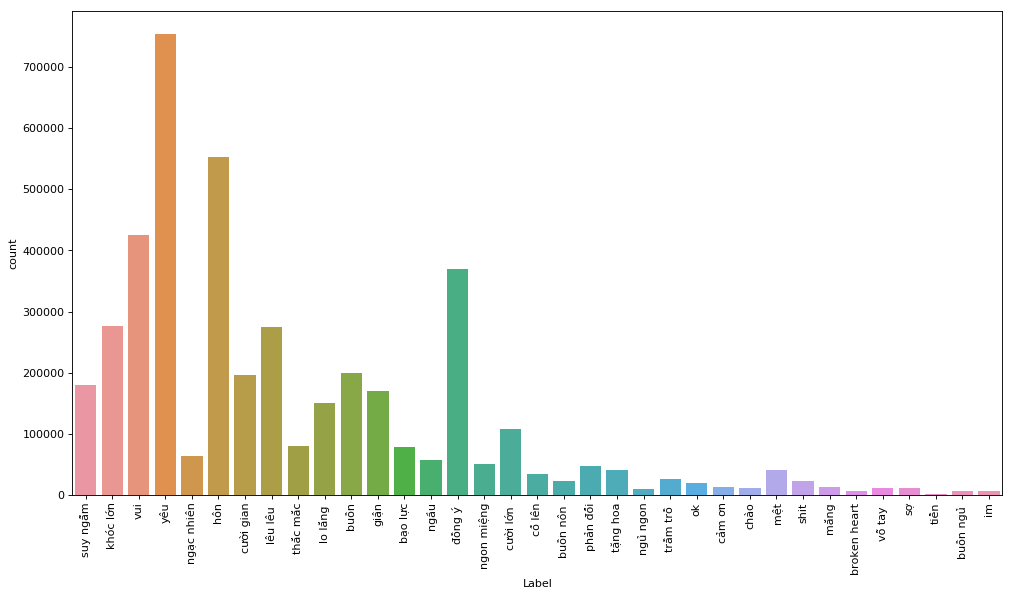

In [4]:
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
sns.countplot(df.label)
plt.xlabel('Label')

In [5]:
X = df.text
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)

In [6]:
onehot_Y = []

for i in range(len(Y)):
    tmp = []
    tmp = [ 0 for i in range(0, 35)] # set all 0
    tmp[Y[i]] = 1 
    onehot_Y.append(tmp)

In [7]:
Y = np.array(onehot_Y)

In [15]:
len(Y)

4321461

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 11)

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11)

# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=11)

In [22]:
max_words = len(X_train)+1
max_len = 30
tok = Tokenizer(num_words = max_words)
X_train = [str(s) for s in X_train]
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [11]:
pickle.dump(tok, open('tokenize.pkl','wb'))

In [12]:
word_dict = pickle.load (open("/data/Data/yntn/word_embedding_vec.pkl",'rb'))

In [23]:
w = np.random.normal(0, 1, (max_words, 300))

In [24]:
for i in range (1, len(tok.index_word)):
    if (tok.index_word[i] in word_dict):
        w[i] = word_dict[tok.index_word[i]]

In [25]:
def RNN():
    inputs = Input(name = 'inputs', shape = [max_len])
    layer = Embedding(max_words, 300, input_length = max_len, weights = [w])(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(35,name = 'out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs = inputs,outputs = layer)
    return model

In [26]:
model  = RNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           1037150700
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 35)                8995      
__________

In [22]:
# Compatible with tensorflow backend
import tensorflow as tf
# def focal_loss(gamma=10, alpha=.25):
def focal_loss(gamma=10, alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [27]:
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(),metrics = ['accuracy'])

## focal loss
# model.compile(loss=[focal_loss(alpha=.25, gamma=10)], metrics=["accuracy"], optimizer='adam')

In [28]:
weight_file = "model_LSTM_w8.hdf5"
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
    ModelCheckpoint(weight_file, monitor = 'val_loss', verbose = 1, save_best_only = True)
]

In [29]:
history = model.fit(sequences_matrix,Y_train,batch_size = 512, epochs = 10,
          validation_split = 0.2, callbacks = callbacks)

/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 1037150700 elements. This may consume a large amount of memory.
  num_elements)
/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 1037150700 elements. This may consume a large amount of memory.
  num_elements)


Train on 2765734 samples, validate on 691434 samples
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[3457169,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/RMSprop/Variable/Assign = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/RMSprop/Variable, training/RMSprop/zeros)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training/RMSprop/Variable/Assign', defined at:
  File "/data/Data/khoint3/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-b34fc6ed861f>", line 2, in <module>
    validation_split = 0.2, callbacks = callbacks)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1010, in fit
    self._make_train_function()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/engine/training.py", line 509, in _make_train_function
    loss=self.total_loss)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/optimizers.py", line 257, in get_updates
    accumulators = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/optimizers.py", line 257, in <listcomp>
    accumulators = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 704, in zeros
    return variable(v, dtype=dtype, name=name)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __init__
    constraint=constraint)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 412, in _init_from_args
    validate_shape=validate_shape).op
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 219, in assign
    validate_shape=validate_shape)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3457169,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/RMSprop/Variable/Assign = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/RMSprop/Variable, training/RMSprop/zeros)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
X_val = [str(s) for s in X_val]
test_sequences = tok.texts_to_sequences(X_val)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_val)

In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [18]:
!ls /data/Data/feed_data



blackwhite_images  feed_raw.log  test
create_bw.py	   images	 train_feed.csv
feed_cleaned.log   new_cat	 train_feed_new.csv


In [15]:
!head emoji2code.json

{
    ":d": "emoji_0",
    ":')": "emoji_1",
    ":-*": "emoji_2",
    "/-heart": "emoji_3",
    "/-strong": "emoji_4",
    ":3": "emoji_5",
    "--b": "emoji_6",
    ":b": "emoji_7",
    ";d": "emoji_8",
    ":~": "emoji_9",
    ":>": "emoji_17",
    ";p": "emoji_11",
    ":*": "emoji_12",
    ";o": "emoji_13",
    ":((((((":"emoji_14",
    ":(((((":"emoji_14",
    ":((((":"emoji_14",
    ":((": "emoji_14",
    ":p": "emoji_16",
    ":$": "emoji_17",
    ":-h": "emoji_18",
    ":-((((((": "emoji_19",
    ":-(((((": "emoji_19",
    ":-((((": "emoji_19",
    ":-(((": "emoji_19",
    ":-((": "emoji_19",
    "x-)": "emoji_20",
    "8-)": "emoji_21",
    ";-d": "emoji_22",
    ":q": "emoji_23",
    "b-)": "emoji_25",
    ";?": "emoji_26",
    ":|": "emoji_27",
    ";xx": "emoji_28",
    ":--|": "emoji_29",
    ";g": "emoji_30",
    ":o": "emoji_31",
    ":z": "emoji_32",
    ":l": "emoji_33",
    "p-(": "emoji_34",
    ":-bye": "emoji_35",
    ":x": "emoji_36",
    "|-)": "emoji_37",
    "